In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage


from skimage.measure import label
from skimage import data
from skimage import color
from skimage.morphology import extrema
from skimage import exposure

from PIL import Image

In [2]:
# Parameters
np.random.seed(3)  # For reproducibility

num_events = 10000


num_tracks = 15
detector_layers = 9
phi_min = 0
phi_max = 0.05*2 * np.pi
phi_sigma = 0.001
n_points = 1
curv_max = 0.01 #0.02
radii = np.linspace(10, 90, detector_layers)

hough_space_size = 256
nthick = 3  # line thickness in accumulator

small_size = 28
tollerance = 3
height = 8 #threshold to find maxima
zero_limit = 9 #anything smaller is set to zero in accumulator

In [3]:
# Function to generate curved tracks
def generate_curved_tracks(num_tracks, radii):
    tracks = []
    track_par = []
    for _ in range(num_tracks):
        curvature = np.random.uniform(-curv_max, curv_max)  # Random curvature based on momentum
        angle = np.random.uniform(phi_min+0.1*(phi_max-phi_min), phi_max-0.1*(phi_max-phi_min))
        hits = [(radius * np.cos(angle+np.random.normal(0,phi_sigma) + curvature * radius),
                 radius * np.sin(angle+np.random.normal(0,phi_sigma) + curvature * radius)) for radius in radii]
        tracks.append(hits)
        track_par.append([angle,curvature])
        #print(curvature, angle)
    return tracks, track_par

# Generate tracks
tracks, track_par = generate_curved_tracks(num_tracks, radii)
#print(tracks)

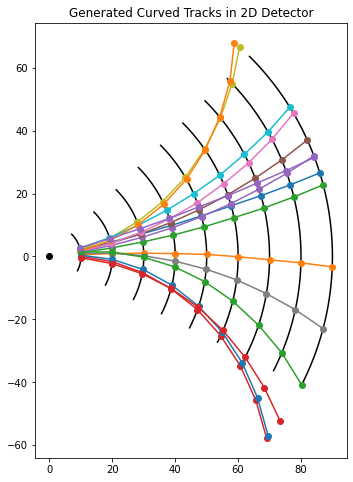

In [4]:
# Plot the generated tracks
def plot_tracks(tracks):
    def plot_partial_circle(R, phi_min, phi_max):
        phi = np.linspace(phi_min, phi_max, 100)  # Create an array of angles from phi_min to phi_max
        x = R * np.cos(phi)
        y = R * np.sin(phi)

        plt.plot(x, y, color="black", label=f'Radius = {R}, ${phi_min} < \\phi < {phi_max}$')


    fig, ax = plt.subplots(figsize=(8,8))
    #plot layers
    for R in radii:
        plot_partial_circle(R, phi_min - 1.5*(phi_max-phi_min), phi_max + 1.5*(phi_max-phi_min))
    #plot tracks
    for hits in tracks:
        x, y = zip(*hits)
        ax.plot(x, y, 'o-')
    ax.set_aspect('equal')
    ax.set_title("Generated Curved Tracks in 2D Detector")

    plt.plot(0,0,'o',color="black")
    plt.show()
    
plot_tracks(tracks)    

In [5]:
# Hough transform

def hough_track(tracks):
    
    # Define the grid for the histogram
    x_bins = np.linspace(phi_min, phi_max, hough_space_size+1)
    y_bins = np.linspace(-2*curv_max, 2*curv_max, hough_space_size+1)
    
    lines=[]
    for tr in tracks:

        # here we generate one thick line
        for ht in tr:
            rh = np.sqrt(ht[0]*ht[0]+ht[1]*ht[1])
            phih = np.arctan2(ht[1], ht[0])
            
            lphi = -phih/rh
            
            line = np.zeros((1,2))
            # Assign values
            line[:, 1] = 1 / rh
            line[:, 0] = lphi
            # Convert to a list of arrays
            lines.extend([line[k] for k in range(line.shape[0])])            
         

    #print(len(lines))        
            
    # fill a histogram of points, the hough_space accumulator
    points = []
    '''# here we generate many lines
    for ll in lines:
        iphi = np.linspace(phi_min, phi_max, hough_space_size)  #*n_points
        icurv = ll[1]*(iphi) + ll[0] # + np.random.normal(0, phi_sigma, hough_space_size*n_points)
        points.extend(list(zip(iphi, icurv)))  # Store (x, y) points
    points = np.array(points)  # Convert to numpy array
    '''
    # here a single line with thicknes nthick
    for ll in lines:
        iphi = np.linspace(phi_min, phi_max, hough_space_size) 
        for nn in range(-nthick // 2, nthick //2):
            icurv = ll[1]*(iphi) + ll[0] + 2*nn * (2*curv_max)/hough_space_size
            points.extend(list(zip(iphi, icurv)))  # Store (x, y) points
    points = np.array(points)  # Convert to numpy array
     
    '''
    # Define the grid for the histogram
    x_bins = np.linspace(phi_min, phi_max, hough_space_size+1)
    y_bins = np.linspace(np.min(points[:, 1]), np.max(points[:, 1]), hough_space_size+1)
    print("y_bins = ",np.min(points[:, 1]), np.max(points[:, 1]))
    '''
    
    hough_space, x_edges, y_edges = np.histogram2d(points[:, 0], points[:, 1], bins=[x_bins, y_bins])     
            
    return lines, hough_space, x_edges, y_edges  

lines, hough_space_hist, x_edges, y_edges = hough_track(tracks)


In [6]:

def find_hough_maxima(hough_space_hist, track_par, height, tol = tollerance, N = small_size, zero_limit=detector_layers):

    print("max = ",np.max(hough_space_hist.T))
    img0 = hough_space_hist.T
    img = np.copy(hough_space_hist.T)
    #img = np.pad(img, pad_width = N // 2, mode='constant', constant_values=0)
    img[img<zero_limit] = 0 
    #img = img/np.max(img)
    #img = hough_space_hist.T/np.max(hough_space_hist.T)


    h_maxima = extrema.h_maxima(img, height)
    label_h_maxima = label(h_maxima)
    overlay_h = color.label2rgb(
        label_h_maxima, img, alpha=0.7, bg_label=0, bg_color=None, colors=[(1, 0, 0)]
    )
    print(type(overlay_h), np.max(overlay_h))

    slices = ndimage.find_objects(label_h_maxima)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)

    x_true =  (np.array(track_par)[:,0]-x_edges[0])/(x_edges[-1]-x_edges[0])*(hough_space_size-1)      
    y_true =  (-np.array(track_par)[:,1]-y_edges[0])/(y_edges[-1]-y_edges[0])*(hough_space_size-1)
    #print(x_true)
    #print(y_true)
   
    x_start = np.array(x) - N // 2
    x_end   = np.array(x) + N // 2
    y_start = np.array(y) - N // 2
    y_end   = np.array(y) + N // 2
    
    small_true = []
    small_false = []   
    #print(len(x_padded), len(x))
    for i in range(len(x)):
        # Check if points x_true,y_true are within the rectangle
        within_rectangle = np.any((x_true >= x[i]-tol) & (x_true < x[i]+tol) 
                                  & (y_true >= y[i]-tol) & (y_true < y[i]+tol))

            
        # Draw rectangle
        # Convert corners to integers
        y_s, y_e = int(x_start[i]) , int(x_end[i])   #!!!!!!!!
        x_s, x_e = int(y_start[i]) , int(y_end[i]) 
        
        #print(x_s,x_e,y_s,y_e)
        x_e, y_e = min(x_e, hough_space_size), min(y_e, hough_space_size)
        
        small = img0[x_s:x_e, y_s:y_e]
        if small.shape == (small_size, small_size):
            if within_rectangle:
                small_true.append(small/num_tracks)
            else:
                small_false.append(small/num_tracks)
        
        # Draw rectangle edges
        mm = np.max(img)/2.
        if within_rectangle:
            mm = np.max(img) 
        img[x_s:x_e, y_s] = mm             # Left edge
        img[x_s:x_e, y_e - 1] = mm         # Right edge
        img[x_s, y_s:y_e] = mm             # Top edge
        img[x_e - 1, y_s:y_e] = mm         # Bottom edge
        
    return img, img0, x, y, x_true, y_true, small_true, small_false

    
img, img0, x, y, x_true, y_true, small_true, small_false = find_hough_maxima(hough_space_hist, track_par, height=height, tol = tollerance, N = small_size)   

print("Num. true points ",len(x_true))
print("Num. reco points ",len(x))
print("Num. ok/false/all ",len(small_true), len(small_false), len(x))



max =  15.0
<class 'numpy.ndarray'> 14.0
Num. true points  15
Num. reco points  61
Num. ok/false/all  14 42 61


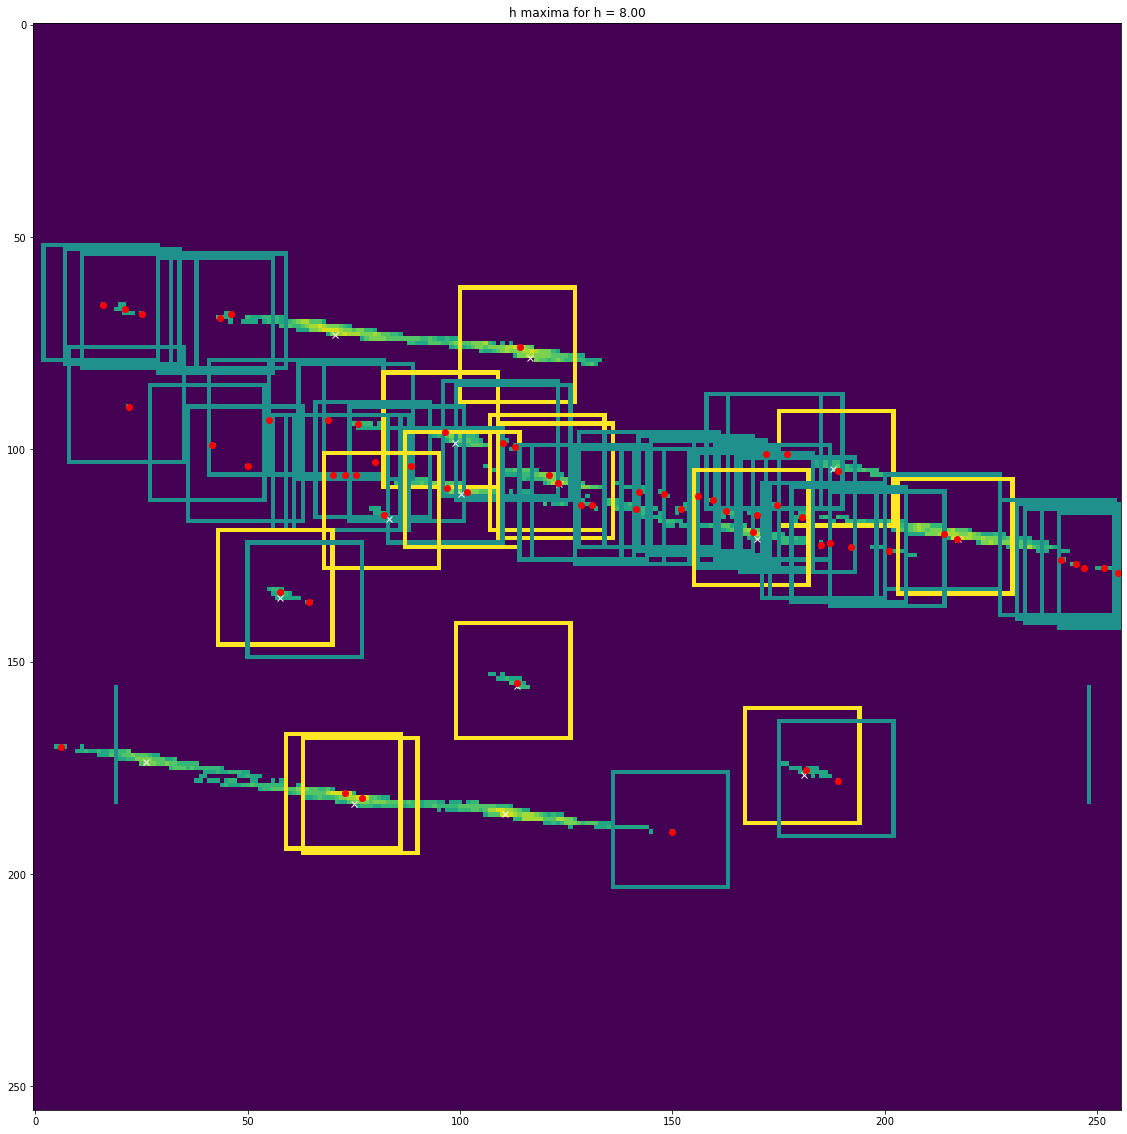

In [7]:

# a new figure with 3 subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

#print(overlay_h.shape)
ax.imshow(img, cmap = "viridis")
ax.set_title(f'h maxima for h = {height:.2f}')
ax.plot(x_true, y_true,'wx')
ax.plot(x,y,"ro")

#ax.axis('off')
plt.show()

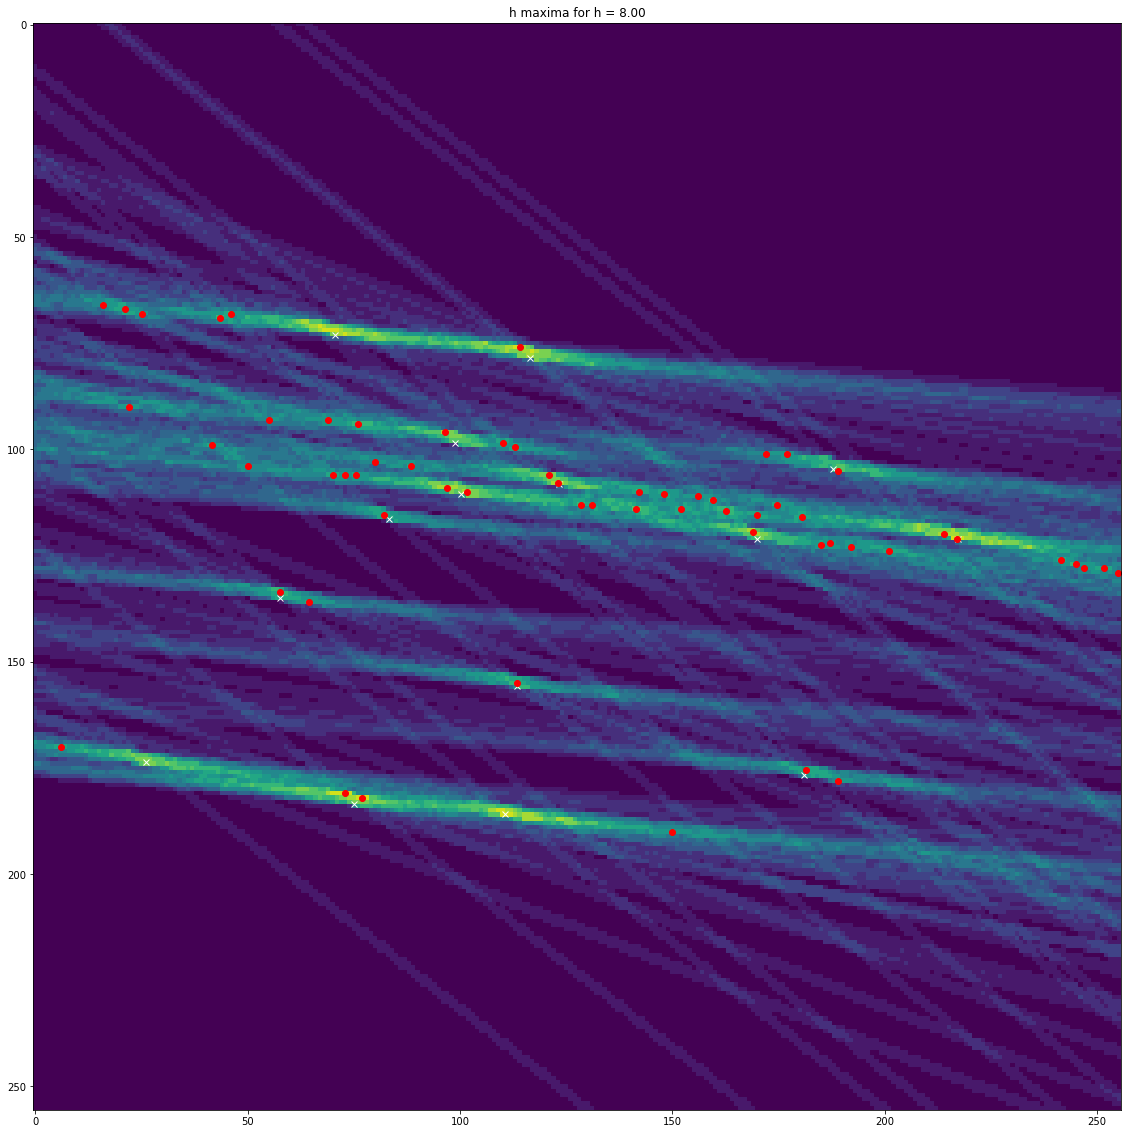

In [19]:

# a new figure with 3 subplots
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

#print(overlay_h.shape)
ax.imshow(img0, cmap = "viridis")
ax.set_title(f'h maxima for h = {height:.2f}')
ax.plot(x_true, y_true,'wx')
ax.plot(x,y,"ro")

#ax.axis('off')
plt.show()

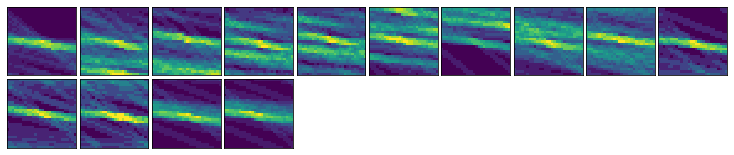

In [15]:
#visualize the TRUE maxima

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(len(small_true)):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(small_true[i], cmap=plt.cm.viridis, interpolation='nearest')


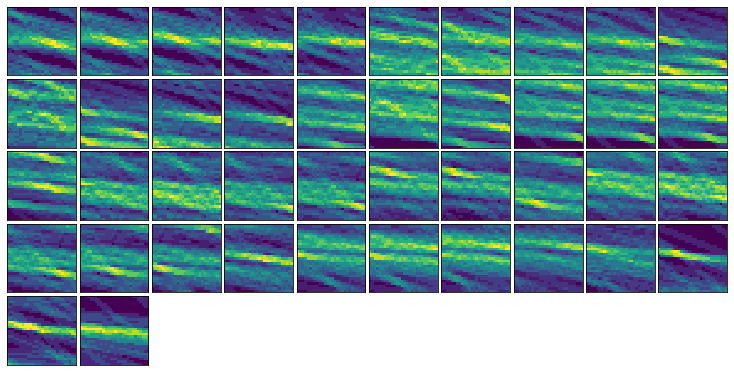

In [16]:
#visualize the FALSE maxima

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(len(small_false)):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(small_false[i], cmap=plt.cm.viridis, interpolation='nearest')


In [9]:
images_true = []
images_false = []
for nn in range(num_events):
    # Generate tracks
    tracks, track_par = generate_curved_tracks(num_tracks, radii)
    # Fill Hough accumulator
    lines, hough_space_hist, x_edges, y_edges = hough_track(tracks)
    # Find Hough maxima
    img, img0, x, y, x_true, y_true, small_true, small_false = find_hough_maxima(hough_space_hist, track_par, height=height, tol = tollerance, N = small_size)
    
    #add images to output
    images_true = images_true + small_true
    images_false = images_false + small_false
    


max =  17.0
<class 'numpy.ndarray'> 16.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 16.0
max =  26.0
<class 'numpy.ndarray'> 24.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  26.0
<class 'numpy.ndarray'> 25.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<cla

<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  28.0
<class 'numpy.ndarray'> 27.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  16.0
<class 'numpy.nd

<class 'numpy.ndarray'> 16.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.nd

max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  13.0
<class 'numpy.ndarray'> 11.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<cla

max =  22.0
<class 'numpy.ndarray'> 21.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  18.0
<cla

max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  21.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<cla

max =  26.0
<class 'numpy.ndarray'> 24.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<cla

max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  23.0
<class 'numpy.ndarray'> 21.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  29.0
<class 'numpy.ndarray'> 28.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  38.0
<class 'numpy.ndarray'> 36.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<cla

max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<cla

max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  13.0
<cla

max =  19.0
<class 'numpy.ndarray'> 18.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  29.0
<class 'numpy.ndarray'> 28.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  29.0
<class 'numpy.ndarray'> 28.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  15.0
<cla

max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  23.0
<class 'numpy.ndarray'> 21.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  14.0
<cla

max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<cla

max =  17.0
<class 'numpy.ndarray'> 16.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  19.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  12.0
<class 'numpy.ndarray'> 11.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<cla

max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  19.0
<cla

max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  21.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  27.0
<class 'numpy.ndarray'> 26.0
max =  27.0
<class 'numpy.ndarray'> 26.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  22.0
<class 'numpy.ndarray'> 20.0
max =  20.0
<cla

max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<cla

max =  22.0
<class 'numpy.ndarray'> 20.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<cla

max =  24.0
<class 'numpy.ndarray'> 23.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  21.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<cla

max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  19.0
<class 'numpy.ndarray'> 17.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  19.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  29.0
<class 'numpy.ndarray'> 28.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<cla

max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  14.0
<cla

max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  26.0
<class 'numpy.ndarray'> 25.0
max =  12.0
<class 'numpy.ndarray'> 11.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  29.0
<class 'numpy.ndarray'> 28.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  20.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  21.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<cla

max =  13.0
<class 'numpy.ndarray'> 12.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  25.0
<class 'numpy.ndarray'> 23.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  12.0
<class 'numpy.ndarray'> 11.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  27.0
<class 'numpy.ndarray'> 26.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<cla

max =  19.0
<class 'numpy.ndarray'> 18.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  28.0
<class 'numpy.ndarray'> 27.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  12.0
<class 'numpy.ndarray'> 11.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<cla

max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<cla

max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<cla

max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  23.0
<class 'numpy.ndarray'> 21.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  22.0
<class 'numpy.ndarray'> 20.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  26.0
<class 'numpy.ndarray'> 23.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  21.0
<cla

max =  14.0
<class 'numpy.ndarray'> 13.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  24.0
<class 'numpy.ndarray'> 22.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<cla

max =  13.0
<class 'numpy.ndarray'> 12.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  22.0
<class 'numpy.ndarray'> 20.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<cla

max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<cla

max =  21.0
<class 'numpy.ndarray'> 20.0
max =  26.0
<class 'numpy.ndarray'> 25.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<cla

max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  22.0
<cla

max =  19.0
<class 'numpy.ndarray'> 18.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<cla

max =  17.0
<class 'numpy.ndarray'> 16.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  16.0
<cla

max =  13.0
<class 'numpy.ndarray'> 12.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  27.0
<class 'numpy.ndarray'> 26.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<cla

max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 16.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  26.0
<class 'numpy.ndarray'> 25.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<cla

max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<cla

max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  28.0
<class 'numpy.ndarray'> 27.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<cla

max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  26.0
<class 'numpy.ndarray'> 25.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<cla

max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<cla

max =  16.0
<class 'numpy.ndarray'> 15.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  21.0
<cla

max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  28.0
<class 'numpy.ndarray'> 27.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  25.0
<class 'numpy.ndarray'> 24.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<cla

max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 19.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<cla

max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  27.0
<class 'numpy.ndarray'> 26.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  22.0
<class 'numpy.ndarray'> 21.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<cla

max =  22.0
<class 'numpy.ndarray'> 21.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  26.0
<class 'numpy.ndarray'> 25.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  29.0
<class 'numpy.ndarray'> 28.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<cla

max =  14.0
<class 'numpy.ndarray'> 13.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  21.0
<cla

max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  19.0
<cla

max =  18.0
<class 'numpy.ndarray'> 17.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<cla

max =  19.0
<class 'numpy.ndarray'> 18.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  23.0
<class 'numpy.ndarray'> 22.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  13.0
<class 'numpy.ndarray'> 12.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<cla

max =  13.0
<class 'numpy.ndarray'> 12.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  21.0
<class 'numpy.ndarray'> 20.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  17.0
<class 'numpy.ndarray'> 16.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  19.0
<class 'numpy.ndarray'> 18.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  14.0
<class 'numpy.ndarray'> 13.0
max =  20.0
<class 'numpy.ndarray'> 19.0
max =  24.0
<class 'numpy.ndarray'> 23.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<class 'numpy.ndarray'> 15.0
max =  20.0
<class 'numpy.ndarray'> 18.0
max =  15.0
<class 'numpy.ndarray'> 14.0
max =  18.0
<class 'numpy.ndarray'> 17.0
max =  16.0
<cla

In [10]:
# Convert the list of arrays into a single numpy array of shape (1000, 28, 28)
array_true = np.stack(images_true, axis=0)  # Stack along a new dimension
array_false = np.stack(images_false, axis=0)  # Stack along a new dimension

#add column with class
y_true = np.ones(array_true.shape[0])
y_false = np.zeros(array_false.shape[0])
print(y_true.shape, array_true.shape)

# Combine arrays along the 0 axis
combined_array = np.vstack((array_true, array_false))
y_combined = np.hstack((y_true, y_false))

# Save the array to disk
np.savez('images', X = combined_array, y = y_combined)

print("Shapes of output arrays: ",combined_array.shape, y_combined.shape)


(129470,) (129470, 28, 28)
Shapes of output arrays:  (479642, 28, 28) (479642,)
